In [78]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
from scipy import ndimage
from scipy.spatial.transform import Rotation
from numpy import linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib.colors as mpl_colors
import matplotlib as mpl

from stl import mesh
from mpl_toolkits import mplot3d

In [2]:
import sys, os
sys.path.insert(1, '../MesonMagMapping/PrettyPlotTools/')
import ParticlePlottingFunctions as ppf
import AdiabaticEquations as Adi
%load_ext autoreload
%autoreload 2

In [3]:
#importing physical constants that are useful from scipy.constants
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
g_n = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0]
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

In [4]:
#addes labels to contour lines nicely
def fmt_lable(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"$k$ = {s}" if plt.rcParams["text.usetex"] else f"$k$ = {s}"

#returns the index of the closest value to N in a list generated 
#from the unique values in a given column of a df
def FindClosest(df, N, val):
    dfun = df[val].unique()
    # print(len(dfun))
    difference_array = np.absolute(dfun-N)
    index = difference_array.argmin()
    return index

In [6]:
"""
Same as above, but with custom axis tick labels
B_arr - array of B values to plot [T]
dx_arr - array of dx value to plot [m]

"""   
def range_forK_customAxis(particleData, Vmin=None, Vmax=None, R_G=False):
    k_array = np.empty((0, 3))
    v_vec = np.array([8, 0, 0])
    
    B_3D_arr, r_3D_arr
    
    # for B in B_arr:
    #     for dbdx in dbdx_arr:
    #         val = Adi.K_equ_dbdx(B, dbdx, vn)
    #         k_array = np.append(k_array, np.array([[B, dbdx, val]]), axis=0)

    for i in range(len(particleData)-1):
            B_1 = particleData[['Bx', 'By', 'Bz']][i]
            B_2 = particleData[['Bx', 'By', 'Bz']][i+1]
            
            val = Adi.K_equ3_14(v_vec, B_3D_arr[i], B_2, r_1, r_2, k_inf_set=False)
            B = B_1
            dx = (r_2 - r_1)
            bdbdx = 
            
            k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dx','k'])
    df["B"] = df["B"]*1e6 #convert to uT
    df["dx"] = df["dx"]*100 #convert to cm
    
    return df

In [33]:
#spaced evenly in log10 space
n = 10
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
db = np.linspace(1e-5, 0.01, n) #T/m
#this implies that all my dx = 1 m -> could change in the future
angle = np.linspace(1, 90, n)

In [77]:
# convert to 2d matrices
Z = np.outer(B_arr.T, B_arr)        # 50x50
X, Y = np.meshgrid(db, angle)    # 50x50

NT = np.product(X.shape)

def B2(row, dim):
    vec1 = np.array([row[1]+row[2],row[3], row[4]])
    # print(vec1)
    theta = np.radians(row[0])
            
    axis = [0,0,1] #z axis
    axis = axis / LA.norm(axis)  # normalize the rotation vector first
    rot = Rotation.from_rotvec(theta * axis)

    vec2 = rot.apply(vec1)  
    # print(vec2)
    if dim==0:
        comp = vec2[0]
    elif dim==1:
        comp = vec2[1]
    else:
        comp = vec2[2]
    return comp 


data = {
    "Angle": np.reshape(Y,NT),
    "db": np.reshape(X,NT),
    "B1_x": np.reshape(Z,NT),
    "B1_y": np.reshape(Z,NT)*0,
    "B1_z": np.reshape(Z,NT)*0,
}

Bdata = pd.DataFrame(data)

Bdata['B2_x'] = Bdata.apply(B2, dim=0, axis=1)
Bdata['B2_y'] = Bdata.apply(B2, dim=1, axis=1)
Bdata['B2_z'] = Bdata.apply(B2, dim=2, axis=1)

Bdata

,Angle,db,B1_x,B1_y,B1_z,B2_x,B2_y,B2_z
0,1.0,0.00001,1.000000e-12,0.0,0.0,0.000010,1.745241e-07,0.0
1,1.0,0.00112,1.994737e-12,0.0,0.0,0.001120,1.954670e-05,0.0
2,1.0,0.00223,3.978974e-12,0.0,0.0,0.002230,3.891887e-05,0.0
3,1.0,0.00334,7.937005e-12,0.0,0.0,0.003339,5.829104e-05,0.0
4,1.0,0.00445,1.583223e-11,0.0,0.0,0.004449,7.766321e-05,0.0
...,...,...,...,...,...,...,...,...
95,90.0,0.00556,1.579057e-08,0.0,0.0,0.000000,5.560016e-03,0.0
96,90.0,0.00667,3.149803e-08,0.0,0.0,0.000000,6.670031e-03,0.0
97,90.0,0.00778,6.283027e-08,0.0,0.0,0.000000,7.780063e-03,0.0
98,90.0,0.00889,1.253298e-07,0.0,0.0,0.000000,8.890125e-03,0.0


In [81]:
def df_K_equ3_14_turn(row, vn=8, k_inf_set=False):
    
    v_vec = np.array([vn, 0, 0])
    
    dx=1
    
    B_1 = np.array([row[2],row[3], row[4]])
    B_2 = np.array([row[5],row[6], row[7]])
    r_1 = np.array([0, 0, 0]) 
    r_2 = np.array([dx, 0, 0])

    return Adi.K_equ3_14(v_vec, B_1, B_2, r_1, r_2, k_inf_set=k_inf_set)

In [84]:
Bdata['k'] = Bdata.apply(df_K_equ3_14_turn, axis=1)


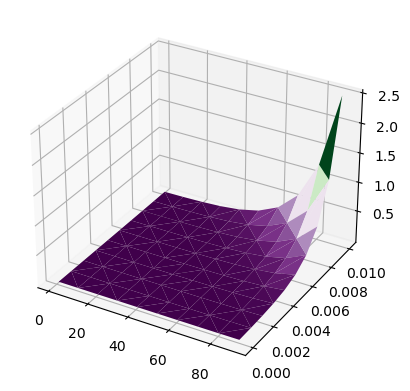

In [92]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(Bdata.Angle, Bdata.db, Bdata.B1_x, cmap='PRGn', linewidth=0.2)
plt.show()

ValueError: Argument Z must be 2-dimensional.

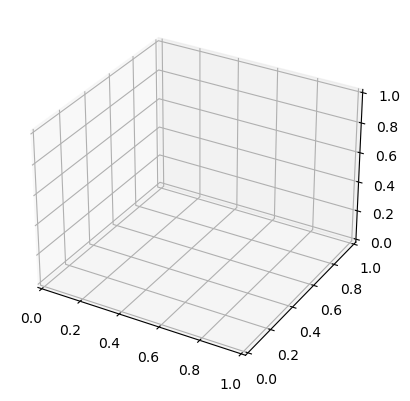

In [93]:
# domains

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = Bdata.k # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()

norm = mpl_colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(Bdata.Angle, Bdata.db, Bdata.B1_x, rstride=1, cstride=1, 
                facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

# fig.colorbar(surf, shrink=1, aspect=1)

ax.set_xlabel("$\\frac{dB}{dx}$ [$\mu$T/cm]")
ax.set_ylabel('Arc length ($\Delta x$) [cm]')
ax.set_zlabel("B [$\mu$T]")

# plt.tight_layout()
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()